<a href="https://colab.research.google.com/github/Mahy-31/CS-Minor-assignment/blob/main/Solution_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import random
import time
import matplotlib.pyplot as plt
from copy import deepcopy

teachers = ['T1', 'T2', 'T3', 'T4', 'T5']
courses = ['C1', 'C2', 'C3', 'C4', 'C5']
rooms = ['R1', 'R2', 'R3']
days = ['Mon','Tue','Wed','Thu','Fri']
periods = [1,2,3,4,5,6,7,8]

variables = courses

teacher_assignment = {course: random.choice(teachers) for course in courses}

def generate_domains():
    domain = []
    for day in days:
        for period in periods:
            for room in rooms:
                domain.append((day, period, room))
    return {course: deepcopy(domain) for course in courses}

In [18]:
def is_consistent(assignment, var, value):
    """Check hard constraints (teacher and room conflicts)"""
    t = teacher_assignment[var]
    day, period, room = value

    for other_var, other_val in assignment.items():
        other_t = teacher_assignment[other_var]
        o_day, o_period, o_room = other_val

        if t == other_t and day == o_day and period == o_period:
            return False
        if room == o_room and day == o_day and period == o_period:
            return False
    return True

def select_unassigned_variable(assignment, domains):
    """MRV heuristic: choose variable with fewest remaining values"""
    unassigned = [v for v in variables if v not in assignment]
    return min(unassigned, key=lambda var: len(domains[var]))

def order_domain_values(var, assignment, domains):
    """LCV heuristic: least constraining value"""
    counts = {}
    for value in domains[var]:
        count = 0
        for other_var in variables:
            if other_var != var and other_var not in assignment:
                count += sum(1 for v in domains[other_var] if not is_consistent({var:value}, other_var, v))
        counts[value] = count
    return sorted(domains[var], key=lambda v: counts[v])

In [13]:
def backtrack_mrv_lcv(assignment, domains, backtrack_counter):
    if len(assignment) == len(variables):
        return assignment
    var = select_unassigned_variable(assignment, domains)
    for value in order_domain_values(var, assignment, domains):
        if is_consistent(assignment, var, value):
            assignment[var] = value
            result = backtrack_mrv_lcv(assignment, domains, backtrack_counter)
            if result:
                return result
            del assignment[var]
            backtrack_counter[0] += 1
    return None

def forward_checking(assignment, domains, backtrack_counter):
    if len(assignment) == len(variables):
        return assignment
    var = select_unassigned_variable(assignment, domains)
    for value in order_domain_values(var, assignment, domains):
        if is_consistent(assignment, var, value):
            assignment[var] = value
            new_domains = deepcopy(domains)
            for other_var in variables:
                if other_var != var and other_var not in assignment:
                    new_domains[other_var] = [v for v in new_domains[other_var] if is_consistent({var:value}, other_var, v)]
                    if not new_domains[other_var]:
                        break
            else:
                result = forward_checking(assignment, new_domains, backtrack_counter)
                if result:
                    return result
            del assignment[var]
            backtrack_counter[0] += 1
    return None

In [14]:
def run_experiments(trials=20):
    mrv_lcv_times = []
    mrv_lcv_backtracks = []
    fc_times = []
    fc_backtracks = []

    last_mrv_lcv = None
    last_fc = None

    for i in range(trials):
        domains = generate_domains()

        backtrack_counter = [0]
        start_time = time.time()
        result = backtrack_mrv_lcv({}, domains, backtrack_counter)
        end_time = time.time()
        mrv_lcv_times.append(end_time - start_time)
        mrv_lcv_backtracks.append(backtrack_counter[0])
        last_mrv_lcv = result

        backtrack_counter = [0]
        start_time = time.time()
        result_fc = forward_checking({}, domains, backtrack_counter)
        end_time = time.time()
        fc_times.append(end_time - start_time)
        fc_backtracks.append(backtrack_counter[0])
        last_fc = result_fc

    return {
        "MRV+LCV": {"times": mrv_lcv_times, "backtracks": mrv_lcv_backtracks},
        "Forward Checking": {"times": fc_times, "backtracks": fc_backtracks},
        "last_assignments": {"MRV+LCV": last_mrv_lcv, "Forward Checking": last_fc}
    }

results = run_experiments(trials=20)

MRV+LCV: Avg Time = 0.08291s, Avg Backtracks = 0.00
Forward Checking: Avg Time = 0.09066s, Avg Backtracks = 0.00


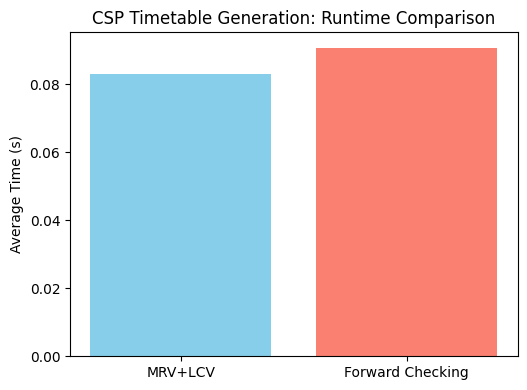

In [17]:
for method in ["MRV+LCV","Forward Checking"]:
    avg_time = sum(results[method]["times"]) / len(results[method]["times"])
    avg_back = sum(results[method]["backtracks"]) / len(results[method]["backtracks"])
    print(f"{method}: Avg Time = {avg_time:.5f}s, Avg Backtracks = {avg_back:.2f}")

methods = ["MRV+LCV","Forward Checking"]
avg_times = [sum(results[m]["times"])/len(results[m]["times"]) for m in methods]
avg_backtracks = [sum(results[m]["backtracks"])/len(results[m]["backtracks"]) for m in methods]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.bar(methods, avg_times, color=['skyblue','salmon'])
plt.ylabel("Average Time (s)")
plt.title("CSP Timetable Generation: Runtime Comparison")

plt.tight_layout()
plt.show()